## 初期設定的なもの

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(x):
    return x*(1 - x)

class Layer:
    def __init__(self, input_size, output_size):
        self.input_size = input_size                           # 入力数
        self.output_size = output_size                         # ニューロン数と同じ
        self.neurons_W = (np.random.rand(output_size, input_size) - 0.5) * 0.1 # ニューロンごとに入力と同数の足がある分の重み
        self.neurons_b = (np.random.rand(output_size) - 0.5) * 0.2             # ニューロンごとのしきい値
        self.neurons_d = np.zeros(output_size)                                 # ニューロンごとの誤差修正値
    
    def h(self, x):
        return sigmoid(x)
        #return tanh(x)
        #return relu(x)
    
    def dh(self, y):
        return dsigmoid(y)
        #return dtanh(y)
        #return drelu(y)

    def output_layer(self, X):
        y = np.zeros(self.output_size)
        for i in range(self.output_size):
            # y = h(sum(W*X) - b)
            y[i] = self.h(np.sum(self.neurons_W[i]*X) - self.neurons_b[i])
        return y

    def train_layer(self, X):
        for i in range(self.output_size):
            # W = W - (-alpha*d*X)
            self.neurons_W[i] -= -alpha*self.neurons_d[i]*X
        return
    
    # 出力層での自分自身の誤差修正値をセット
    def backprop_layer_output(self, O, T):
        # d = (T - O)*dh(O)
        self.neurons_d = (T - O)*self.dh(O)
        return

    # 前のレイヤーへの誤差修正値を算出
    def backprop_layer(self):
        total_prev_D = np.zeros(self.input_size)
        for i in range(self.output_size):
            #total_prev_D += W*d
            total_prev_D += self.neurons_W[i]*self.neurons_d[i]
        return total_prev_D

    # 後のレイヤーで計算された誤差修正値に出力値を掛けて自レイヤーに値をセット
    def set_layer_d(self, D, O):
        # d = D*dh(O)
        self.neurons_d = D*self.dh(O)


In [4]:
def smaller(image):
    def seri(x, y):
        return y*28 + x

    simages = np.zeros(14*14)
    for i in range(14):
        for j in range(14):
            x, y = j*2, i*2
            avg = (image[seri(x+0, y+0)] + image[seri(x+0, y+1)] + image[seri(x+1, y+0)] + image[seri(x+1, y+1)])/4.0
            simages[i*14 + j] = avg
    return simages

In [5]:
plt.figure(figsize=(20,10))

In [6]:
def plotInput(image, w, h, x, y):
    plt.subplot(w, h, y*w + x + 1)
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray_r, interpolation="nearest")


## numpyで配列の範囲の扱い

In [19]:
test1 = np.array([[11, 12, 13, 14], [21, 22, 23, 24], [31, 32, 33, 34]])

In [ ]:
test1[1:3, 0:2]

In [ ]:
test2 = test1[1:3, 0:2]

In [ ]:
test2[:] = test2 * 2

In [20]:
test1

array([[11, 12, 13, 14],
       [21, 22, 23, 24],
       [31, 32, 33, 34]])

In [21]:
test1.shape

(3, 4)

In [22]:
test1.reshape(3, 4, 1)

array([[[11],
        [12],
        [13],
        [14]],

       [[21],
        [22],
        [23],
        [24]],

       [[31],
        [32],
        [33],
        [34]]])

In [ ]:
test1.reshape(-1)

In [ ]:
test1.reshape(-1).reshape(2, 3, 2)

In [ ]:
test1

In [ ]:
test1.max()

In [ ]:
test1.max(axis=1)

In [ ]:
test3 = test1.reshape(-1).reshape(2, 3, 2)

In [ ]:
test3

In [ ]:
test3.max(axis=2)

In [14]:
test4 = np.array([[["R11", "G11", "B11"], ["R12", "G12", "B12"], ["R13", "G13", "B13"], ["R14", "G14", "B14"]],
                  [["R21", "G21", "B11"], ["R22", "G22", "B12"], ["R23", "G23", "B23"], ["R24", "G23", "B24"]]])

In [15]:
test4

array([[['R11', 'G11', 'B11'],
        ['R12', 'G12', 'B12'],
        ['R13', 'G13', 'B13'],
        ['R14', 'G14', 'B14']],

       [['R21', 'G21', 'B11'],
        ['R22', 'G22', 'B12'],
        ['R23', 'G23', 'B23'],
        ['R24', 'G23', 'B24']]], 
      dtype='<U3')

In [16]:
test4.shape

(2, 4, 3)

In [18]:
(h, w, d) = test4.shape

In [ ]:
test4.transpose((2, 0, 1))

In [ ]:
test4.transpose((2, 0, 1)).shape

## convolutionとpoolingの順方向実装

In [23]:
def conv(layer, X):
    (height, width, depth) = X.shape # 入力は3次元配列を想定
    # convolution 3x3 の入力の畳み込み層を使う
    (conv_width, conv_height) = 3, 3
    (conv_out_width, conv_out_height) = width - (conv_width - 1), height - (conv_height - 1)
    conv_out = np.zeros((conv_out_height, conv_out_width, 20))  # 縦12 x 横12 x 種20 の出力結果用
    for y in range(conv_out_height):
        for x in range(conv_out_width):
            window = X[y:y+conv_height, x:x+conv_width] # 窓を切り出す
            conv_out[y, x] = layer.output_layer(window.reshape(-1)) # 窓は2次元配列なので1次元化してニューロンに渡す
            #print("y:" + str(y) + " x:" + str(x) + " data:" + str(window))
            #plotInput(inp[y:y+ch, x:x+cw], w, h, x, y)
    return conv_out

In [30]:
layer1 = Layer(3*3, 20) # 3x3の入力で20種類まで判定出来るたたみこみ層
layer1.neurons_W = (np.random.rand(layer1.output_size, layer1.input_size) - 0.5) * 1.0 # わかりやすくするため重み初期値を大きくする

alpha = 0.1
fig = plt.figure(figsize=(8, 6))

def test_convolution(train_count):
    images, labels = mnist.train.next_batch(train_count)
    square_error = 0.0
    for i in range(len(images)):
        X = smaller(images[i]).reshape(14, 14, 1) # 3次元配列で入力
        C = conv(layer1, X)

        #print("conv:\n" + str(C))
        plt.subplot(3, 5, 1)
        plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
        plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
        plt.imshow(X.reshape(14, 14), vmin=0, vmax=1, cmap=plt.cm.gray_r, interpolation="nearest")
        images = C.transpose((2, 0, 1)) # 出力を特徴抽出ニューロン毎に取り出せるように配列順番を入れ替える
        for j in range(5):
            image = images[j]
            plt.subplot(3, 5, j + 5 + 1)
            plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
            plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
            plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray_r, interpolation="nearest")

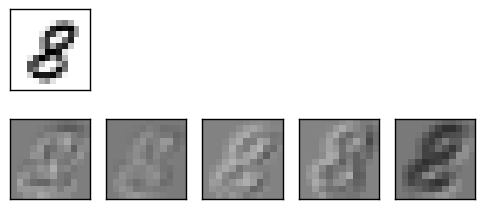

In [31]:
test_convolution(1)

In [11]:
def pooling(conv_out):
    (conv_out_h, conv_out_w, conv_out_z) = conv_out.shape
    # pooling 2x2 の範囲で最大のものを抽出
    (pw, ph) = 2, 2
    pooling_out = np.zeros((conv_out_h // ph, conv_out_w // pw, conv_out_z))  # 縦6 x 横6 x 種20 の出力結果用
    for z in range(conv_out_z):
        for y in range(0, conv_out_h, ph):
            for x in range(0, conv_out_w, pw):
                window = conv_out[y:y+ph, x:x+pw, z]
                value = window.max()
                index = window.argmax()
                pooling_out[y // ph, x // pw, z] = value # そのpoolingで最大のものを詰める
                #print("y:" + str(max_y) + " x:" + str(max_x) + " z:" + str(z) + " value:" + str(value))
    return pooling_out

In [12]:
def test_pooling(train_count):
    images, labels = mnist.train.next_batch(train_count)
    square_error = 0.0
    for i in range(len(images)):
        X = smaller(images[i]).reshape(14, 14)
        C = conv(layer1, X)
        P = pooling(C)

        #print("conv:\n" + str(C))
        #print("pooling:\n" + str(P))
        plt.subplot(3, 5, 1)
        plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
        plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
        plt.imshow(X, vmin=0, vmax=1, cmap=plt.cm.gray_r, interpolation="nearest")
        images = C.transpose((2, 0, 1))
        for j in range(5):
            image = images[j]
            plt.subplot(3, 5, j + 5 + 1)
            plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
            plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
            plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray_r, interpolation="nearest")
        images = P.transpose((2, 0, 1))
        for j in range(5):
            image = images[j]
            plt.subplot(3, 5, j + 10 + 1)
            plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
            plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
            plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray_r, interpolation="nearest")


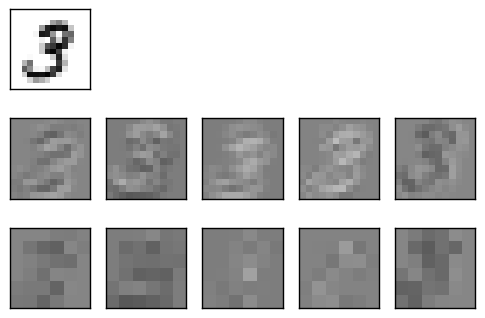

In [13]:
test_pooling(1)

## 学習の実装

In [32]:
class Clayer:
    def __init__(self, conv_width, conv_height, output_depth):
        self.output_depth = output_depth
        (self.width, self.height, self.depth) = 0, 0, 0
        (self.conv_width, self.conv_height) = conv_width, conv_height # convolution 3x3 の入力の畳み込み層を使う
        self.conv_layer = Layer(self.conv_width*self.conv_height, output_depth) # 3x3の入力で20種類まで判定出来るたたみこみ層

    def output_layer(self, X):
        (self.height, self.width, self.depth) = X.shape # 入力は3次元配列を想定
        (conv_out_width, conv_out_height) = self.width - (self.conv_width - 1), self.height - (self.conv_height - 1)
        conv_out = np.zeros((conv_out_height, conv_out_width, 20))  # 縦12 x 横12 x 種20 の出力結果用
        for y in range(conv_out_height):
            for x in range(conv_out_width):
                window = X[y:y+conv_height, x:x+conv_width] # 窓を切り出す
                conv_out[y, x] = self.conv_layer.output_layer(window.reshape(-1)) # 窓は2次元配列なので1次元化してニューロンに渡す
        return conv_out

    # 出力層での自分自身の誤差修正値をセット
    def backprop_layer_output(self, O, T):
        for y in range(conv_out_height):
            for x in range(conv_out_width):
                window = X[y:y+conv_height, x:x+conv_width] # 窓を切り出す
                conv_out[y, x] = self.conv_layer.output_layer(window.reshape(-1)) # 窓は2次元配列なので1次元化してニューロンに渡す
        self.conv_layer.backprop_layer_output(conv_out[y, x], T)
        return

    # 後のレイヤーで計算された誤差修正値に出力値を掛けて自レイヤーに値をセット
    def set_layer_d(self, D, O):
        # d = D*dh(O)
        self.neurons_d = D*self.dh(O)

    # 前のレイヤーへの誤差修正値を算出
    def backprop_layer(self):
        total_prev_D = np.zeros(self.input_size)
        for i in range(self.output_size):
            #total_prev_D += W*d
            total_prev_D += self.neurons_W[i]*self.neurons_d[i]
        return total_prev_D

    def train_layer(self, X):
        for i in range(self.output_size):
            # W = W - (-alpha*d*X)
            self.neurons_W[i] -= -alpha*self.neurons_d[i]*X
        return